In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

%matplotlib inline

# Baseline Model

## Import DataFrames

This baseline takes the data that was scraped on October 14. Files are located in the data folder which is also inside this project 3 folder

In [12]:
college = pd.read_csv('./data/college_oct14')
grad_school = pd.read_csv('./data/grad_school_oct14')

In [13]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2888 entries, 0 to 2887
Data columns (total 6 columns):
title           2888 non-null object
body            2339 non-null object
num_comments    2888 non-null int64
up_votes        2888 non-null int64
age             2888 non-null float64
subreddit       2888 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 135.5+ KB


In [14]:
grad_school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741 entries, 0 to 3740
Data columns (total 6 columns):
title           3741 non-null object
body            2986 non-null object
num_comments    3741 non-null int64
up_votes        3741 non-null int64
age             3741 non-null float64
subreddit       3741 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 175.5+ KB


We check this data and we notice that thre is a lot of missing objects in the body field. This isn't too big of a deal for us because some of the threads may not have had body text. We will fill in all null values with an empty space.

Then we will append the college and grad school dataframe on top of each other so we can examne all data at the same time.

In [15]:
#replacing all null values with a space
college = college.replace(np.nan, " ")
grad_school = grad_school.replace(np.nan, " ")

In [16]:
#appending the dataframes together 
c_gs = college.append(grad_school)
# making sure all information looks correct
c_gs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6629 entries, 0 to 3740
Data columns (total 6 columns):
title           6629 non-null object
body            6629 non-null object
num_comments    6629 non-null int64
up_votes        6629 non-null int64
age             6629 non-null float64
subreddit       6629 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 362.5+ KB


Now that the data is merged together, we will take the title and body column and create a new column called all_text. We do this so we can examine all text data regardless if there was a body post or not. THen we will create a column that counds the amount of words in each thread post.

In [17]:
#combining all text of title and body into one column
c_gs['all_text'] = c_gs['title'] + ' ' + c_gs['body']
c_gs = c_gs.drop(['title', 'body'], axis = 1)
c_gs['word_count'] = c_gs['all_text'].apply(lambda x: len(x.split()))
c_gs = c_gs.reset_index(drop=True)

In [18]:
c_gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6629 entries, 0 to 6628
Data columns (total 6 columns):
num_comments    6629 non-null int64
up_votes        6629 non-null int64
age             6629 non-null float64
subreddit       6629 non-null object
all_text        6629 non-null object
word_count      6629 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 310.9+ KB


We remove punctuation so that there is no confusion when running data through different classifers

In [9]:
#remove punctuation
c_gs['all_text'] = c_gs['all_text'].str.replace('[^\w\s]','')

In [17]:
c_gs.head()

,num_comments,up_votes,age,subreddit,all_text
0,435,88,47.065377,college,FAFSAfinancial aid verification questions Get ...
1,1,2,0.006776,college,Failed my midterm I failed my midterm and I wa...
2,1,1,0.008998,college,Professor gives butt load of homework but is o...
3,0,1,0.013535,college,Does a GPA round up My girlfriend is graduatin...
4,0,1,0.017274,college,Should I take CALC II Im a freshman Biochem Ma...


In [18]:
c_gs['subreddit'].value_counts(normalize = True)

GradSchool    0.564339
college       0.435661
Name: subreddit, dtype: float64

We are assiging GradSchool the variable of 1 and college the variable of 0. We want GradSchool to be our target variable because they seem to be the most active on reddit, and we want to gain more insight into Grad Students needs as there especially since there are more undergrad resources on most campus'.

In [19]:
#map, change the labels of Subreddit 
#grad_school = 1, college = 0
c_gs['subreddit'] = c_gs['subreddit'].map({'college': 0, 'GradSchool' : 1})
c_gs.head()

,num_comments,up_votes,age,subreddit,all_text
0,435,88,47.065377,0,FAFSAfinancial aid verification questions Get ...
1,1,2,0.006776,0,Failed my midterm I failed my midterm and I wa...
2,1,1,0.008998,0,Professor gives butt load of homework but is o...
3,0,1,0.013535,0,Does a GPA round up My girlfriend is graduatin...
4,0,1,0.017274,0,Should I take CALC II Im a freshman Biochem Ma...


In [20]:
c_gs['subreddit'].value_counts()

1    3741
0    2888
Name: subreddit, dtype: int64

We have 3741 gradschool posts and 2888 college posts

**Quick EDA:**

From the graph below, we can see that most grad_school threads contain morre word count compared to college posts.

Text(0, 0.5, 'UP Votes')

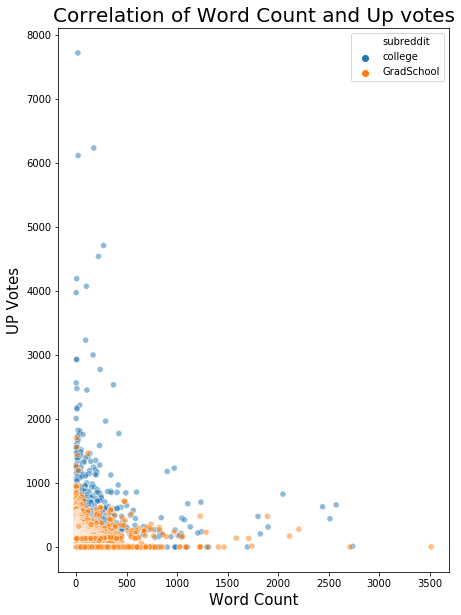

In [36]:
fig, ax = plt.subplots(1,1,figsize=(7,10))
ax = sns.scatterplot(x="word_count", y="up_votes", hue="subreddit",
                      data=c_gs, alpha = 0.5)
plt.title('Correlation of Word Count and Up votes', fontsize = 20)
plt.xlabel("Word Count", fontsize = 15)
plt.ylabel("UP Votes", fontsize = 15)

In [42]:
c_gs.groupby('subreddit').describe().T

subreddit            GradSchool      college
num_comments count  3741.000000  2888.000000
             mean     15.552259    33.063019
             std      24.611077    77.685079
             min       0.000000     0.000000
             25%       3.000000     4.000000
             50%       7.000000    10.000000
             75%      18.000000    34.000000
             max     503.000000  1510.000000
up_votes     count  3741.000000  2888.000000
             mean     87.075114   172.486842
             std     156.648786   426.293619
             min       0.000000     0.000000
             25%       1.000000     1.000000
             50%       3.000000     3.000000
             75%     153.000000   218.250000
             max    1704.000000  7717.000000
age          count  3741.000000  2888.000000
             mean    515.507431   553.553714
             std     683.735331   698.657687
             min       0.020906     0.006776
             25%      19.503962     9.874424
             50%      84.477028   269.045952
             75%     864.100482   809.924745
             max    2935.404463  3089.204724
word_count   count  3741.000000  2888.000000
             mean    135.705961   134.266274
             std     177.843743   190.833764
             min       1.000000     1.000000
             25%      32.000000    33.000000
             50%      93.000000    85.000000
             75%     172.000000   164.000000
             max    3515.000000  2737.000000

## Modeling

In [23]:
stop_words= list(ENGLISH_STOP_WORDS)
len(stop_words)

318

In [27]:
c_gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6629 entries, 0 to 6628
Data columns (total 6 columns):
num_comments    6629 non-null int64
up_votes        6629 non-null int64
age             6629 non-null float64
subreddit       6629 non-null int64
all_text        6629 non-null object
word_count      6629 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 310.9+ KB


In [28]:
#determine X and Y variables
X = c_gs['all_text']
y = c_gs['subreddit']

In [36]:
y_test.value_counts(normalize=True)

1    0.564103
0    0.435897
Name: subreddit, dtype: float64

In [37]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=248)

In [40]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [39]:
pipe_params = {
    'cvec__max_features': [1000, 1500, 2000],
    'cvec__min_df': [3,6],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2), (2,3)],    
}

In [40]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=5) 

In [41]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

C:\Users\Brianna Lytle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cvec__max_features': [1000, 1500, 2000], 'cvec__min_df': [3, 6], 'cvec__max_df': [0.9, 0.95], 'cvec__ngram_range': [(1, 1), (1, 2), (2, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
gs.best_score_

0.8806034482758621

In [43]:
gs_model = gs.best_estimator_

In [44]:
gs_model

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=2000, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [45]:
log_feature_names = gs_model.named_steps['cvec'].get_feature_names()

In [46]:
log_feature_coef = gs_model.named_steps['lr'].coef_[0]

In [47]:
log_feature_exp = [np.exp(i) for i in log_feature_coef]

In [48]:
feature_dict = {
    
    'feature_names' : log_feature_names,
    'feature_coef' : log_feature_coef,
    'feature_exp' : log_feature_exp
    
}

bline_model_words = pd.DataFrame(feature_dict)

In [49]:
bline_model_words.head()

,feature_names,feature_coef,feature_exp
0,10,-0.212435,0.808613
1,100,0.093284,1.097774
2,1000,-0.010112,0.989939
3,11,0.167714,1.182599
4,12,0.295087,1.343243


In [50]:
bline_model_words.sort_values(by = 'feature_exp', ascending = True).head(15)

,feature_names,feature_coef,feature_exp
351,college,-3.021708,0.048718
505,dorm,-2.016026,0.133184
352,colleges,-1.820324,0.161973
701,freshman,-1.811449,0.163417
1045,major,-1.489821,0.225413
281,campus,-1.482158,0.227147
663,finals,-1.449290,0.234737
1960,wont,-1.378602,0.251931
1483,roommate,-1.321289,0.266791
751,gone,-1.266828,0.281724


In [51]:
top_15 = bline_model_words.sort_values(by = 'feature_exp', ascending = False).head(15)

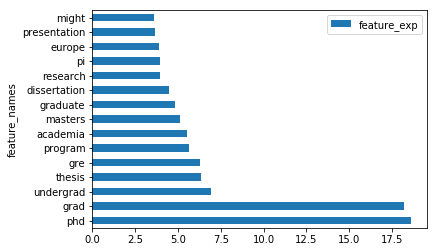

In [52]:
top_15.plot.barh(x= 'feature_names', y = 'feature_exp')

### ROC AUC Curve for Baseline model

In [25]:
custom_stop = list(ENGLISH_STOP_WORDS)

In [56]:
cvec = CountVectorizer(lowercase=True, max_df=0.9, max_features=2000, ngram_range = (1,1), min_df=3)
c_gs_matrix = (cvec.fit_transform(c_gs['all_text']))
c_gs_df = pd.DataFrame(c_gs_matrix.toarray(),
                        columns = cvec.get_feature_names())
c_gs_df['subreddit'] = c_gs['subreddit']
c_gs_df.head()

,10,100,1000,11,12,13,14,15,18,19,...,yet,you,youll,young,your,youre,yourself,youtube,youve,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,8,0,0,6,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [57]:
X = c_gs_df.loc[:, c_gs_df.columns !='subreddit']
y = c_gs_df['subreddit']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 248)

lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\Brianna Lytle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [59]:
preds = lr.predict(X_test)
confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [60]:
spec = tn / (tn + fp)
sens = tp / (tp + fn)
print(f'Baseline Model Specificity: {round(spec,4)}')
print(f'Baseline Model Sensitivity: {round(sens,4)}')

Baseline Model Specificity: 0.8718
Baseline Model Sensitivity: 0.9146


In [61]:
pred_proba = [i[1] for i in lr.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

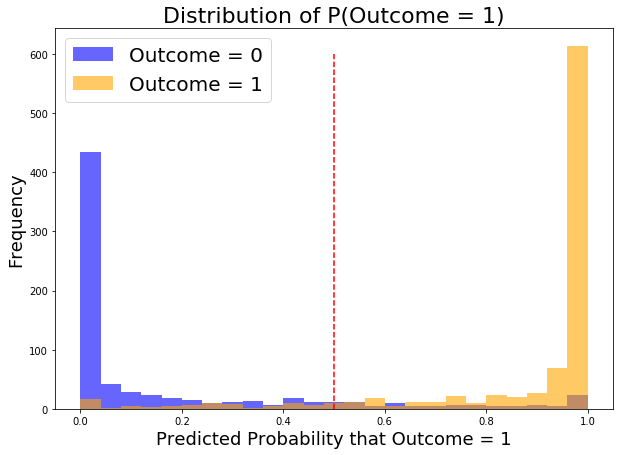

In [63]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 600,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

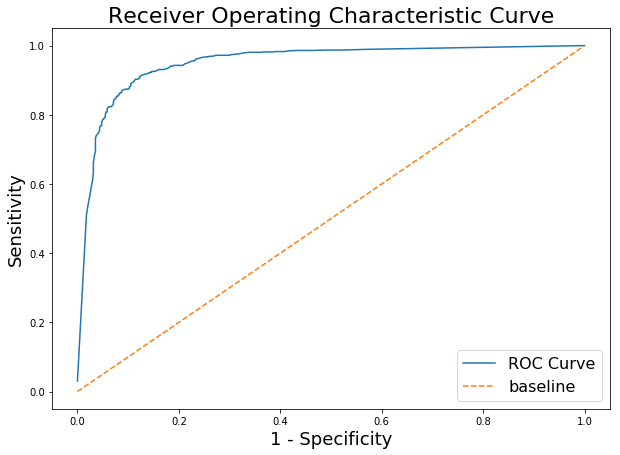

In [64]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

# Baseline Model Conclusion

The only EDA that was done here was combining the word counts of the subreddits. By using a simple CVEC score, with the following custom features:
- max_df=0.9, max_features=2000, ngram_range = (1,1), min_df=3

These features led to an accuracy score of **0.8806034482758621** . I put this data into a confusion matrix and the Baseline Model Specificity is 0.8718 and Baseline Model Sensitivity is 0.9146. So this model is pretty strong.